Ignore jupyter notebook warnings

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Import Requiremnts

In [2]:
!python -m pip install -r requirements.txt

## Import libs

In [3]:
import requests, re, descartes, folium, json, os, dotenv
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

## Functions used in the notebooks

In [4]:
## Functions for web scraping into wikipedia
def get_neighborhoods_url(*args):
    neighborhoods_url = {}
    page = requests.get("https://pt.wikipedia.org/wiki/Lista_de_bairros_do_Rio_de_Janeiro_por_IDH")
    soup = BeautifulSoup(page.content, "html.parser")
    table = soup.find("table", class_="wikitable sortable")
    result = table.find_all("a")
    for neighborhood in args:
        for i in range(0,len(result)):
            if neighborhood == result[i].get_text():
                neighborhoods_url[result[i].get_text()] = f"https://pt.wikipedia.org/{result[i].get('href')}"
                break   #after find the value, break the last loop
    return neighborhoods_url

def get_html_content(**kwargs):
    neighborhoods_soup = {}
    for name, url in kwargs.items():
        page = requests.get(url)
        soup = BeautifulSoup(page.content, "html.parser") 
        neighborhoods_soup[name] = soup
    return neighborhoods_soup

def get_population_density(**kwargs):
    neighborhoods_density = {}
    for name, soup in kwargs.items():
        if name == "Copacabana":
            ##Area
            result_area_raw = soup.find("td", string="Área\n").find_next_sibling("td").get_text()
            #Convert "," to "." as decimal separator
            result_area_raw = result_area_raw.replace(',','.')
            #1 km2 = 100 ha
            result_area = float(result_area_raw.split(' ')[0].strip())*100
            
            ##Population
            result_habit_raw = soup.find("td", string="Habitantes\n").find_next_sibling("td").get_text()
            result_habit = result_habit_raw.split('(')
            result_habit = float(result_habit[0].replace(' ',''))
        else:
            ##Area
            result_area_raw = soup.find("a", string="Área total").parent.find_next_sibling("td").get_text()
            #Convert "," to "." as decimal separator
            result_area_raw = result_area_raw.replace(',','.')
            result_area = float(result_area_raw.split(' ')[0].strip())
            
            ##Population
            result_habit_raw = soup.find("a", string="População total").parent.find_next_sibling("td").get_text()
            #Pick up the first part of the expression
            result_habit = result_habit_raw.split('(')[0]
            #remove spaces and ',' and u"\xa0"
            result_habit = float(re.sub('[" ",u"\xa0"]','',result_habit))
            
        result_density = result_habit/result_area
        neighborhoods_density[name] = "%.2f" % result_density
    return neighborhoods_density

def get_population_idh(**kwargs):
    neighborhoods_idh = {}
    for name, soup in kwargs.items():
        if name == "Copacabana":
            result_idh_raw = soup.find("td", string="IDH\n").find_next_sibling("td").get_text()
            result_idh_raw = result_idh_raw.replace(',','.')
            result_idh = float(result_idh_raw.split('[')[0].strip())    
        else:
            result_idh_raw = soup.find("a", string="IDH").parent.find_next_sibling("td").get_text()
            result_idh_raw = result_idh_raw.replace(',','.')
            result_idh = float(result_idh_raw.split('[')[0].strip())    
        neighborhoods_idh[name] = "%.3f" % result_idh
    return neighborhoods_idh

#function to save jsonfile
def save_json(json_var, filename):
    with open(filename, 'w') as json_file:
        json.dump(json_var, json_file)

#function to load jsonfile
def load_json(filename):
    f = open(filename)
    return json.load(f)
        
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# function to filter info of the dataframe
def df_filter(df_search):
    filtered_columns = ['id','name','categories','location.address','location.lat','location.lng','location.distance']
    df_search_filtered = df_search.loc[:, filtered_columns]
    
    # filter the category for each row
    df_search_filtered['categories'] = df_search_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    df_search_filtered.columns = [column.split('.')[-1] for column in df_search_filtered.columns]
    return df_search_filtered

def min_max(value, mini, maxi):
    #The number '3' was necessary to avoid very small numbers and distort the graph 
    return (value - mini + 3)/(maxi - mini)

# Introduction:
The bakery is a type of commercial enterprise in which its target audience is mainly formed by people who live in the surroundings of the place, given the nature of the business. Thus, in order to plan the installation of a new bakery, it is essential to analyze places where there are deficiencies in serving the public in your region.

# Methodology:
We will be going to use the Foursquare API and the population density data that was extracted from Wikipedia Page, whose source of this data is the Rio de Janeiro city hall website. 

# Acquiring Data

## Neighborhoods analyzed
The Neighborhoods of this study model will be those of the South Zone of the city of Rio de Janeiro

Neighborhoods included:
<ul>
  <li>Gávea</li>
  <li>Leblon</li>
  <li>Ipanema</li>
  <li>Lagoa</li>    
  <li>Flamengo</li>
  <li>Catete</li>
  <li>Humaitá</li>
  <li>Laranjeiras</li>
  <li>Jardim Botânico</li>
  <li>Copacabana</li>
  <li>Leme</li>
  <li>Botafogo</li>
  <li>Urca</li>
</ul>

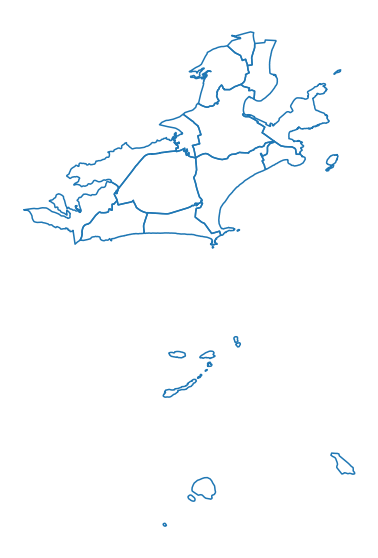

In [5]:
neighborhoods = ['Gávea', 'Leblon', 'Ipanema', 'Lagoa', 'Flamengo', 'Catete', 'Humaitá', 'Laranjeiras', 'Jardim Botânico', 'Copacabana', 'Leme', 'Botafogo', 'Urca']
#Source of the .shp file: https://www.data.rio/datasets/limite-bairro
df = gpd.read_file("files/Limite_de_Bairros.shp", encoding='utf-8')
df_neighborhoods_map = df[df['NOME'].isin(neighborhoods)].to_crs(epsg='4326').reset_index(drop=True)
ax = df_neighborhoods_map.boundary.plot(figsize=(20, 10))
ax.set_axis_off()

In [6]:
neighborhoods_map_json = df_neighborhoods_map.to_json()

##Another option is open the file
#neighborhoods_map_json = load_json('files/mapa_bairros.json')

## Acquiring data from Wikipedia

### Get the Wikipedia url of the neighborhoods of Rio to acquire the data

In [7]:
#Get the wikipedia url of the neighborhoods of Rio to acquire the data
neighborhoods_dict = get_neighborhoods_url(*neighborhoods)

### Get the html of the wikipedia pages

In [8]:
soup_content = get_html_content(**neighborhoods_dict)

### Get the population density of the neighborhoods of Rio

In [9]:
density = get_population_density(**soup_content)

### Get the population IDH of the neighborhoods of Rio

In [10]:
idh = get_population_idh(**soup_content)

## Acquire data from Foursquare

### Defining variables
We will use two expressions in Portuguese ('Padaria' and 'Panificação') that represents "bakery" to have a greater amount of results

In [11]:
#Using dotenv to store credentials
values = dotenv.dotenv_values('../.env')
CLIENT_ID = values.get('CLIENT_ID')
CLIENT_SECRET = values.get('CLIENT_SECRET')
ACCESS_TOKEN = values.get('ACCESS_TOKEN')

search_query_1 = 'Padaria'
search_query_2 = 'Panificação'

LIMIT = 500
radius = 6000
VERSION = '20180604'

#Center point of the region
latitude, longitude = -22.970679380651823, -43.2000329423211

### Define the corresponding URL (search)

In [12]:
url1 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query_1, radius, LIMIT)
url2 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query_2, radius, LIMIT)

#### Make a query to the API

In [13]:
results_search_padaria = requests.get(url1).json()
results_search_panificacao = requests.get(url2).json()

#### Save/load the json file to avoid making new calls

In [14]:
#padaria
#save_json(results_search_padaria, filename='files/results_search_padaria.json')
#results_search_padaria = load_json(filename='files/results_search_padaria.json')

#panificação
#save_json(results_search_panificacao, filename='files/results_search_panificacao.json')
#results_search_panificacao = load_json(filename='files/results_search_panificacao.json')

#### Put the data in a dataframe

In [15]:
# assign relevant part of JSON to venues
padaria = results_search_padaria['response']['venues']
panificacao = results_search_panificacao['response']['venues']

# tranform venues into a dataframe
df_search_padaria = pd.json_normalize(padaria)
df_search_panificacao = pd.json_normalize(panificacao)

#### Define information of interest and filter dataframe

In [16]:
df_padaria_filtered = df_filter(df_search_padaria)
df_panificacao_filtered = df_filter(df_search_panificacao)

### Define the corresponding URL (explore)

In [17]:
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)

#### Make a query to the API

In [18]:
results_explore = requests.get(url).json()

#### Save/load the json file to avoid making new calls

In [19]:
#save_json(results_explore, filename='files/results_explore.json')
results_explore = load_json(filename='files/results_explore.json')

#### Put the data in a dataframe

In [20]:
items = results_explore['response']['groups'][0]['items']
df_explore = pd.json_normalize(items) # flatten JSON

## Data manipulation

### Define information of interest and filter dataframe

In [21]:
# filter columns
filtered_columns = ['venue.id','venue.name','venue.categories','venue.location.address','venue.location.lat','venue.location.lng','venue.location.distance']
df_explore_filtered = df_explore.loc[:, filtered_columns]

# filter the category for each row
df_explore_filtered['venue.categories'] = df_explore_filtered.apply(get_category_type, axis=1)

# clean columns
df_explore_filtered.columns = [col.split('.')[-1] for col in df_explore_filtered.columns]

df_explore_filtered.head(5)

,id,name,categories,address,lat,lng,distance
0,50aa7f9ee4b0024ee0e6ac52,Parque Lagoa Rodrigo de Freitas,Playground,NaN,-22.976007,-43.200301,593
1,4b05872cf964a520538322e3,Parque Natural Municipal da Catacumba,Park,"Av. Epitácio Pessoa, 3000",-22.972665,-43.203165,389
2,4d97e7ea647d8cfaa99ce23d,Parque do Cantagalo,Park,"Av. Epitácio Pessoa, s/n",-22.973705,-43.203213,468
3,4bcafd133740b713a59e6165,Parcão da Lagoa,Dog Run,Lagoa Rodrigo de Freitas,-22.978130,-43.199873,829
4,54c56d75498efefa010e605c,Supermercado Zona Sul,Supermarket,"R. Dias da Rocha, 29",-22.972668,-43.189203,1131


### Compare the size of the dataframes and merge them

In [22]:
print(f"df_padaria_filtered.shape: {df_padaria_filtered.shape}")
print(f"df_panificacao_filtered.shape: {df_panificacao_filtered.shape}")
print(f"df_explore_filtered.shape: {df_explore_filtered.shape}")

df_padaria_filtered.shape: (50, 7)
df_panificacao_filtered.shape: (31, 7)
df_explore_filtered.shape: (100, 7)


In [23]:
df_bakery = pd.concat([df_padaria_filtered, df_panificacao_filtered, df_explore_filtered])

### Clean the data of the dataframe

In [24]:
#Remove duplicates
df_bakery.drop_duplicates(inplace=True)
#Choose only bakeries
df_bakery = df_bakery.loc[df_bakery['categories'] == 'Bakery']
#Reset index
df_bakery.reset_index(drop=True, inplace=True)

### Create a GeoDataFrame

In [25]:
geo_df_bakery = gpd.GeoDataFrame(df_bakery, geometry = gpd.points_from_xy(df_bakery.lng, df_bakery.lat))

### Add new colums in the geo_df_bakery with the neighborhood's respective data

In [26]:
for i in range(len(df_neighborhoods_map)):
    #For each neighborhood
    geom = df_neighborhoods_map.iloc[[i]]['geometry'].item()
    for j, value in geo_df_bakery.within(geom).items():
        #check if the points are inside the neighborhood
        if value == True:
            #Add neighborhood name
            geo_df_bakery.loc[j,'neighborhood'] = df_neighborhoods_map.iloc[i,2]
            #Add neighborhood's density info
            geo_df_bakery.loc[j,'density'] = density[df_neighborhoods_map.iloc[i,2]]
            #Add neighborhood's idh info
            geo_df_bakery.loc[j,'idh'] = idh[df_neighborhoods_map.iloc[i,2]]

### Drop the points out of the region of interest and reset index

In [27]:
geo_df_bakery.dropna(subset=['neighborhood'], inplace=True)
geo_df_bakery.reset_index(drop=True, inplace=True)
geo_df_bakery.shape

(54, 11)

### Check the map

In [41]:
bakery_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred at the red point

# add a red marker to represent the center of the region
folium.CircleMarker(
    [latitude, longitude],
    radius=2,
    color='red',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(bakery_map)

folium.Circle(
    [latitude, longitude],
    radius=6000,
    color='blue',
    fill = False,
    fill_opacity = 0.6
).add_to(bakery_map)

folium.GeoJson(neighborhoods_map_json).add_to(bakery_map)

#add the bakeries to the map
for lat, lng, label, density in zip(geo_df_bakery.lat, geo_df_bakery.lng, geo_df_bakery.name, geo_df_bakery.density):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='black',
        popup=label,
        fill = True,
        fill_color='orange',
        fill_opacity=0.7
    ).add_to(bakery_map)

# display map
bakery_map

### Adjust some data type

In [29]:
geo_df_bakery[["density"]] = geo_df_bakery[["density"]].astype("float")
geo_df_bakery[["idh"]] = geo_df_bakery[["idh"]].astype("float")

In [30]:
geo_df_bakery_adjusted=geo_df_bakery.copy()
for i in range(len(geo_df_bakery_adjusted)):
    geo_df_bakery_adjusted.loc[i,'density'] = min_max(value=geo_df_bakery_adjusted['density'].to_list()[i],mini=30.45,maxi=357.05)

### Check the map again

In [42]:
bakery_map = folium.Map(location=[latitude, longitude], zoom_start=14) # generate map centred at the red point

# add a red marker to represent the center of the region
folium.CircleMarker(
    [latitude, longitude],
    radius=2,
    color='black',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(bakery_map)

folium.Circle(
    [latitude, longitude],
    radius=6000,
    color='blue',
    fill = False,
    fill_opacity = 0.6
).add_to(bakery_map)

folium.GeoJson(neighborhoods_map_json).add_to(bakery_map)

#add the bakeries to the map
for lat, lng, label, density in zip(geo_df_bakery_adjusted.lat, geo_df_bakery_adjusted.lng, geo_df_bakery_adjusted.name, geo_df_bakery_adjusted.density):
    folium.CircleMarker(
        [lat, lng],
        radius=1/density,
        color='orange',
        popup=label,
        fill = True,
        fill_color='orange',
        fill_opacity=0.7
    ).add_to(bakery_map)

# display map
bakery_map

## K-Means Clustering

### Define the dataframe

In [43]:
geo_df_bakery_kmeans = geo_df_bakery_adjusted[['density','idh']]

### Elbow Method

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

(1.0, 10.0)

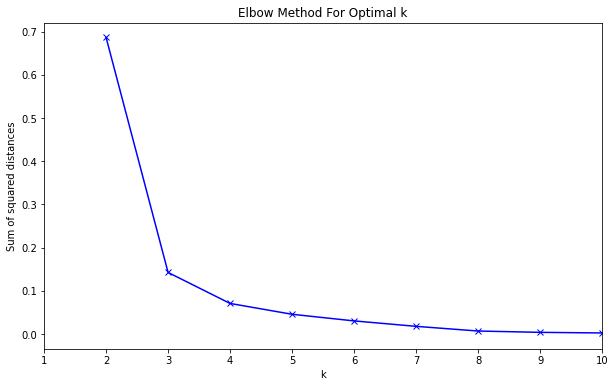

In [44]:
sum_of_squared_distances = []
K = range(2,20)

for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=100).fit(geo_df_bakery_kmeans)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.title('Elbow Method For Optimal k')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.xlim([1, 10])


### K-Means Method

In [47]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, n_init=100).fit(geo_df_bakery_kmeans)
kmeans.fit(geo_df_bakery_kmeans)
cluster_labels = kmeans.predict(geo_df_bakery_kmeans)
kmeans_labels = kmeans.labels_

In [48]:
df_cluster_labels = pd.DataFrame(cluster_labels, columns = ['cluster_labels'])
geo_df_bakery_adjusted_kmeans = pd.concat([geo_df_bakery_adjusted, df_cluster_labels], axis=1)

### Silhouette Score

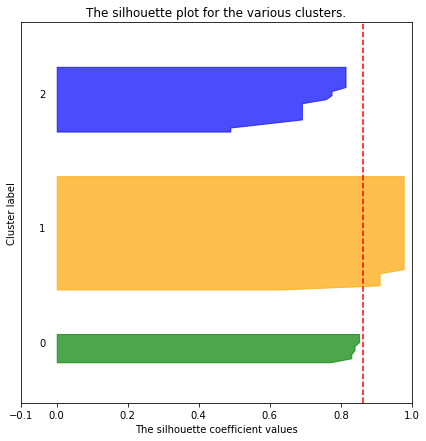

In [49]:
y_lower = 10
silhouette_avg = silhouette_score(geo_df_bakery_kmeans, cluster_labels)
sample_silhouette_values = silhouette_samples(geo_df_bakery_kmeans, cluster_labels)
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
ax.set_ylim([0, len(geo_df_bakery_kmeans) + (kclusters + 1) * 10])
for i in range(kclusters):
  # Aggregate the silhouette scores for samples belonging to
  # cluster i, and sort them
  ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

  ith_cluster_silhouette_values.sort()

  size_cluster_i = ith_cluster_silhouette_values.shape[0]
  y_upper = y_lower + size_cluster_i

  color_pallet = ['green', 'orange', 'blue']
  ax.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,facecolor=color_pallet[i], edgecolor=color_pallet[i], alpha=0.7)

  # Label the silhouette plots with their cluster numbers at the middle
  ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

  # Compute the new y_lower for next plot
  y_lower = y_upper + 10  # 10 for the 0 samples

ax.set_title("The silhouette plot for the various clusters.")
ax.set_xlabel("The silhouette coefficient values")
ax.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--")

ax.set_yticks([])  # Clear the yaxis labels / ticks
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

## Result

### Map after clustering

In [50]:
bakery_map = folium.Map(location=[latitude, longitude], zoom_start=14) # generate map centred at the red point

# add a red marker to represent the center of the region
folium.CircleMarker(
    [latitude, longitude],
    radius=2,
    color='black',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(bakery_map)

folium.Circle(
    [latitude, longitude],
    radius=6000,
    color='blue',
    fill = False,
    fill_opacity = 0.6
).add_to(bakery_map)

folium.GeoJson(neighborhoods_map_json).add_to(bakery_map)

#add the bakeries to the map
color_pallet = ['green', 'orange', 'blue']
for lat, lng, label, density, color_index in zip(geo_df_bakery_adjusted_kmeans.lat, geo_df_bakery_adjusted_kmeans.lng, geo_df_bakery_adjusted_kmeans.name, geo_df_bakery_adjusted_kmeans.density, geo_df_bakery_adjusted_kmeans.cluster_labels):
    folium.CircleMarker(
        [lat, lng],
        radius=1/density,
        color=color_pallet[color_index],
        popup=label,
        fill=True,
        fill_color= color_pallet[color_index],
        fill_opacity=0.7
    ).add_to(bakery_map)

# display map
bakery_map

### Comparison between clusters

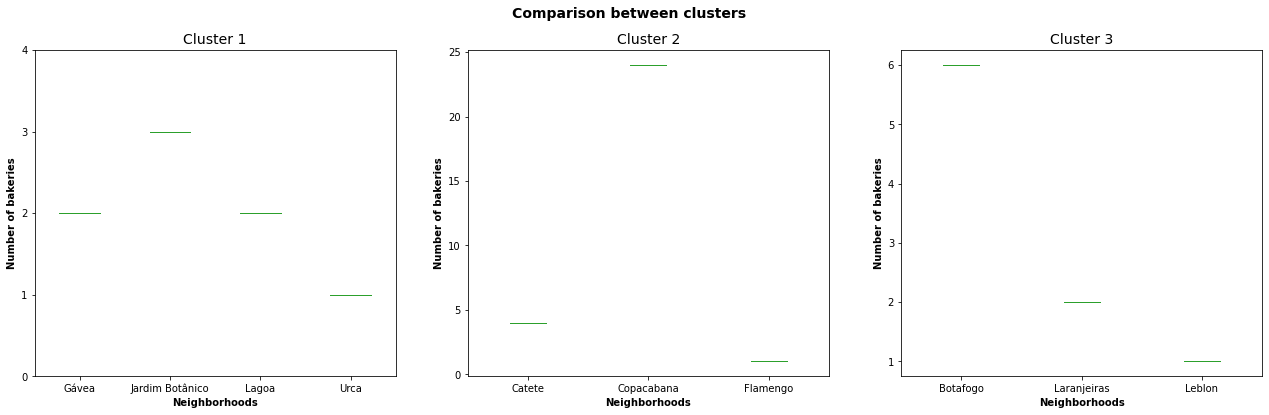

In [51]:
df_crosstab = pd.crosstab(geo_df_bakery_full['cluster_labels'], geo_df_bakery_full['neighborhood'])
df_crosstab.replace(0,np.nan, inplace=True)
color_pallet = ['green', 'orange', 'blue']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
#fig.set_size_inches(6, 7)
plt.title('')
ax1.set_title('Cluster 1', fontsize=14)
ax1.set_xlabel('Neighborhoods', fontweight='bold')
ax1.set_ylabel('Number of bakeries', fontweight='bold')
df_crosstab.loc[[0]].dropna(axis=1).plot(kind='box', figsize=(22, 6), yticks=(np.arange(0, 5, step=1)), ax=ax1)

ax2.set_title('Cluster 2', fontsize=14)
ax2.set_xlabel('Neighborhoods', fontweight='bold')
ax2.set_ylabel('Number of bakeries', fontweight='bold')
df_crosstab.loc[[1]].dropna(axis=1).plot(kind='box', figsize=(22, 6), ax=ax2)

ax3.set_title('Cluster 3', fontsize=14)
ax3.set_xlabel('Neighborhoods', fontweight='bold')
ax3.set_ylabel('Number of bakeries', fontweight='bold')
df_crosstab.loc[[2]].dropna(axis=1).plot(kind='box', figsize=(22, 6), ax=ax3)

plt.suptitle('Comparison between clusters',fontsize=14, fontweight='bold')
plt.show()